# Data Cleaning and EDA


**Overview:** This notebook goes through data cleaning and exploratory data analysis in order to prepare for model building.

Specifically, we'll be walking through:

1. **Getting the data:** In this case, the data is stored in an SQL table
2. **Exploratory Data Analysis (EDA):** Visualizing the data to understand the distribution and correlation of different features.
3. **Data Cleaning:** Basic pre-processing techniques

The output of this notebook will be clean, organized data stored as a serialized (pickled) dataframe.

## Problem Statement
Build a predictive model that assigns default probabilities to loan applications and it is similar to what our credit modeling team is doing. Predict the probability that a customer is going to default (target=1) or not (target=0).

**Assumption:** The dataset provided contains credit and loan information about users and whether they have defaulted or not.

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

## Data Gathering

In [2]:
# Connect to database
conn = psycopg2.connect("dbname=sample user=hiring password=g~+oc2ABz#-GE+u%pQ3Z host=anyfin-work-sample.cn2fqd2vd4bc.eu-west-1.rds.amazonaws.com")

# Activation connection cursor
#cur = conn.cursor()

# Run query and display
#cur.execute("SELECT * FROM creditdataset")
#rows = cur.fetchall()
#rows

df = pd.read_sql("SELECT * FROM creditdataset", conn)

# Close connections
#cur.close()
conn.close()

In [3]:
df.head()

,id,external_score,income_tax,credit_used,e_mal_count,a_mal_count,credit_count,income_gross,capital_income,salary_surplus,...,day,hour_1,contact_channel,email_domain,lender_id,customer_postal,loan_interest,loan_fee,loan_type,target
0,0eedb807-e20b-41e2-be30-9a60f7dbdb7a,19.33400,57500.0,204080.0,0.0,0.0,8.0,238800.0,0.0,260400.0,...,28.0,17.0,7.0,11.0,13.0,65224.0,19.90,29.0,pos,1.0
1,318d2ac4-b724-4691-b148-5ae0b5859953,0.60314,45400.0,367.0,0.0,0.0,1.0,216800.0,0.0,216900.0,...,16.0,19.0,7.0,1.0,77.0,73141.0,19.90,29.0,pos,0.0
2,6da47c66-2933-4b26-8847-c4d1d4c8fcc5,30.46367,43500.0,579783.0,0.0,0.0,13.0,221000.0,0.0,276600.0,...,18.0,15.0,7.0,2.0,86.0,79252.0,133.57,0.0,blanco-,1.0
3,26563d53-e703-4437-a500-d9f54b05bffd,33.22719,47000.0,315891.0,0.0,0.0,9.0,205000.0,0.0,278900.0,...,6.0,22.0,7.0,1.0,13.0,NaN,19.90,29.0,pos,1.0
4,7ecf362c-9fb4-4b22-a890-91c8862e74ae,24.68127,3600.0,1033.0,0.0,0.0,1.0,46000.0,0.0,46600.0,...,27.0,14.0,7.0,3.0,13.0,NaN,19.90,29.0,pos,1.0


In [4]:
df.shape

(1200, 40)

In [5]:
print(df.columns.values)

['id' 'external_score' 'income_tax' 'credit_used' 'e_mal_count'
 'a_mal_count' 'credit_count' 'income_gross' 'capital_income'
 'salary_surplus' 'credit_approved' 'creditors_count' 'income_employment'
 'has_spouce' 'customer_age' 'credit_used_instalment' 'capital_deduction'
 'inquiries_count' 'credit_used_blanco' 'payment_remarks_amount'
 'e_mal_active_amount' 'a_mal_active_amount' 'debt_requests_count'
 'housing_rent' 'blanco_amount' 'credit_card_amount' 'housing_base_cost'
 'inquiries_count_12m' 'big_city' 'credit_used_account' 'day' 'hour_1'
 'contact_channel' 'email_domain' 'lender_id' 'customer_postal'
 'loan_interest' 'loan_fee' 'loan_type' 'target']


**Note:** Since ultimately, the goal will be to pick the best features to build the predictive model, it is important to learn as much as possible about the data. In my case, I don't have the time, or resources to learn what each one of the columns truly represent. I will limit my exploration of the data to the columns that make the most sense and proceed with my prediction. 

In [6]:
df.describe()

,external_score,income_tax,credit_used,e_mal_count,a_mal_count,credit_count,income_gross,capital_income,salary_surplus,credit_approved,...,credit_used_account,day,hour_1,contact_channel,email_domain,lender_id,customer_postal,loan_interest,loan_fee,target
count,1200.000000,1199.000000,1.200000e+03,1200.000000,1200.000000,1200.000000,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1040.000000,1200.000000,1200.000000,1200.000000
mean,11.263577,56284.403670,7.081267e+05,0.058333,0.003333,6.091667,2.300869e+05,3.283833e+03,2.434728e+05,7.259532e+05,...,26226.438333,18.570000,13.604167,5.551667,5.725000,45.864167,46801.670192,22.983700,20.400750,0.350000
std,16.420758,52965.539229,1.126815e+06,1.068901,0.057663,4.524230,1.535522e+05,4.399655e+04,1.514555e+05,1.136383e+06,...,39849.675382,8.188568,5.270417,2.547431,5.651046,50.091883,26462.164683,33.742204,14.874686,0.477168
min,0.010520,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,1.000000,0.000000,1.000000,1.000000,12.000000,7032.000000,0.000000,0.000000,0.000000
25%,1.157820,23900.000000,3.066850e+04,0.000000,0.000000,3.000000,1.281250e+05,0.000000e+00,1.377250e+05,3.995825e+04,...,0.000000,13.000000,10.000000,7.000000,1.000000,13.000000,21437.750000,16.990000,0.000000,0.000000
50%,3.503290,51500.000000,2.262270e+05,0.000000,0.000000,5.000000,2.290000e+05,0.000000e+00,2.448500e+05,2.367225e+05,...,11937.500000,20.000000,14.000000,7.000000,2.000000,20.000000,44887.500000,19.900000,29.000000,0.000000
75%,14.811427,72500.000000,9.005428e+05,0.000000,0.000000,9.000000,3.045750e+05,0.000000e+00,3.276000e+05,9.105708e+05,...,37401.250000,25.000000,18.000000,7.000000,14.000000,74.000000,71133.250000,19.900000,29.000000,1.000000
max,94.954950,841900.000000,1.048949e+07,31.000000,1.000000,30.000000,1.749600e+06,1.030400e+06,1.784600e+06,1.051175e+07,...,500495.000000,31.000000,23.000000,7.000000,14.000000,267.000000,98138.000000,910.000000,150.000000,1.000000


## Exploratory Data Analysis (EDA)

In [43]:
df.isna().sum().sort_values(ascending=False)

customer_postal           160
housing_base_cost           1
income_tax                  1
loan_type                   1
income_employment           1
housing_rent                1
blanco_amount               1
credit_card_amount          1
target                      0
customer_age                0
has_spouce                  0
creditors_count             0
salary_surplus              0
credit_approved             0
capital_deduction           0
capital_income              0
income_gross                0
credit_count                0
a_mal_count                 0
e_mal_count                 0
credit_used                 0
external_score              0
credit_used_instalment      0
payment_remarks_amount      0
inquiries_count             0
credit_used_blanco          0
e_mal_active_amount         0
a_mal_active_amount         0
debt_requests_count         0
inquiries_count_12m         0
big_city                    0
credit_used_account         0
day                         0
hour_1    

In [41]:
df.nunique().sort_values(ascending=True)

debt_requests_count          1
housing_rent                 1
housing_base_cost            1
target                       2
has_spouce                   2
a_mal_count                  2
big_city                     2
a_mal_active_amount          5
loan_type                    5
contact_channel              5
e_mal_count                  6
email_domain                13
e_mal_active_amount         15
creditors_count             17
hour_1                      24
loan_fee                    26
credit_count                27
day                         31
capital_income              43
customer_age                52
payment_remarks_amount      56
inquiries_count             72
inquiries_count_12m         72
lender_id                   95
loan_interest              209
capital_deduction          408
credit_used_instalment     524
income_tax                 647
blanco_amount              684
credit_used_blanco         685
credit_card_amount         693
credit_used_account        694
customer

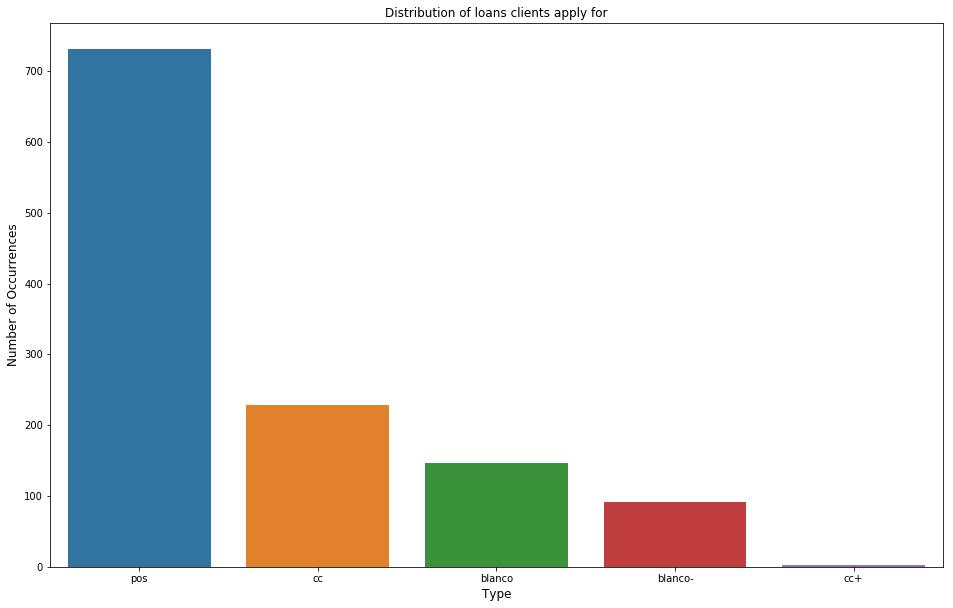

In [8]:
loan_type = df["loan_type"].value_counts()

plt.figure(figsize=(16,10))
sns.barplot(loan_type.index, loan_type.values)
plt.title('Distribution of loans clients apply for')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type', fontsize=12)
plt.show()

**Observations:** Most popular loan type is "pos"

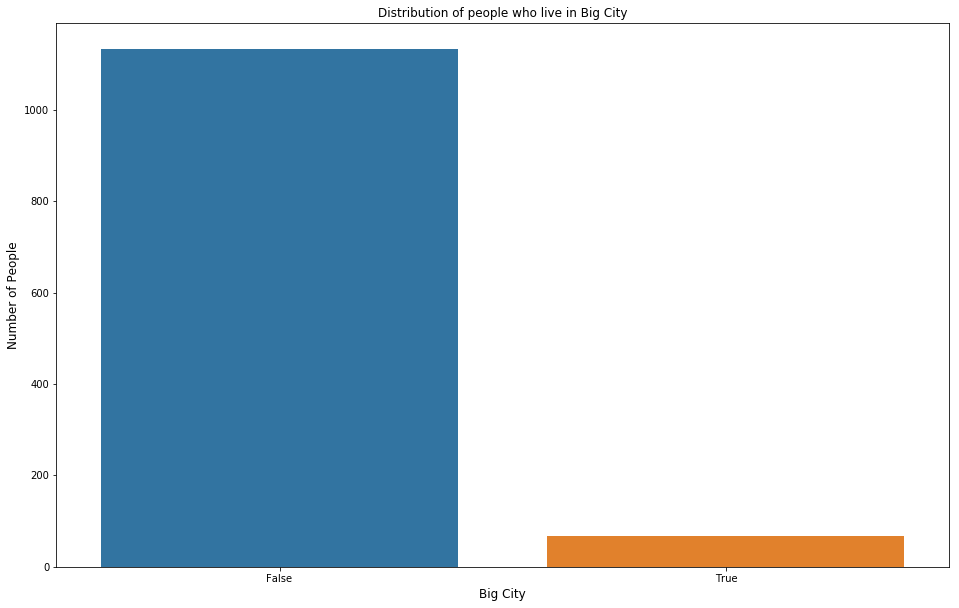

In [9]:
big_city = df["big_city"].value_counts()

plt.figure(figsize=(16,10))
sns.barplot(big_city.index, big_city.values)
plt.title('Distribution of people who live in Big City')
plt.ylabel('Number of People', fontsize=12)
plt.xlabel('Big City', fontsize=12)
plt.show()

**Observations:** 

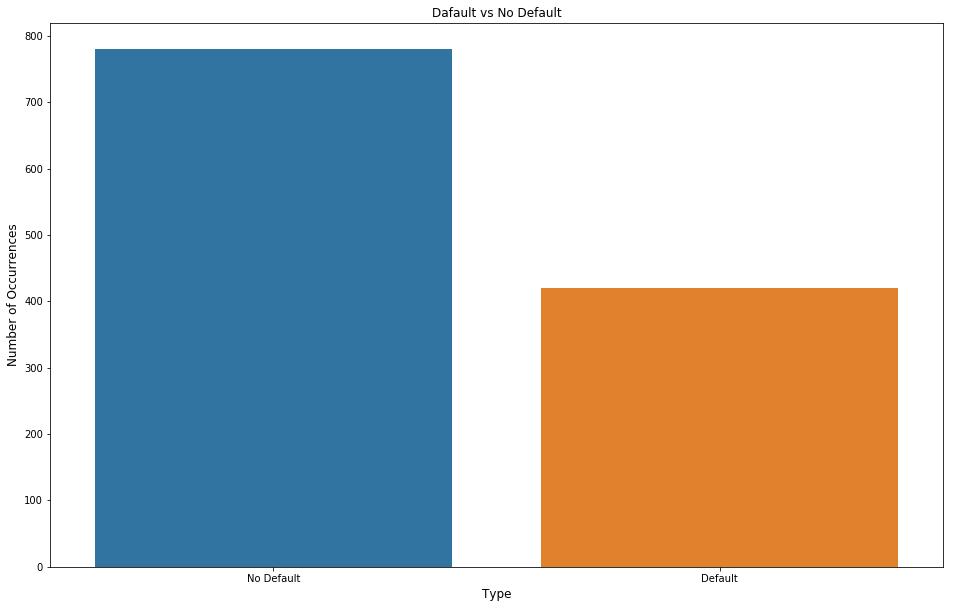

In [10]:
target = df["target"].map({0:"No Default", 1:"Default"}).value_counts()

plt.figure(figsize=(16,10))
sns.barplot(target.index, target.values)
plt.title('Dafault vs No Default')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type', fontsize=12)
plt.show()

**Observations:** As we can see, most people on the dataset don't default, this means that the data is unbalanced and training on this dataset might not give us the best predictive model

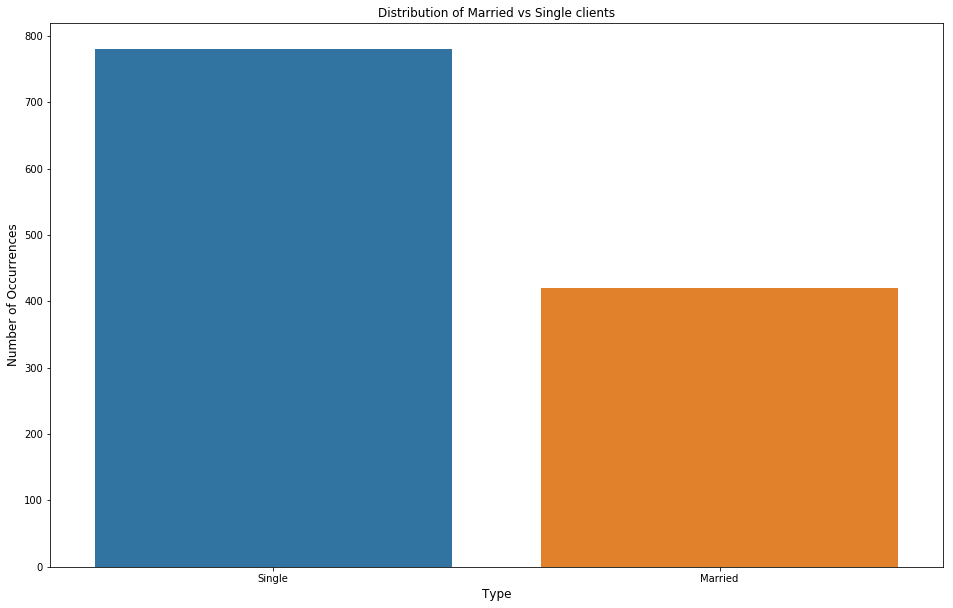

In [55]:
spouse = df["target"].map({0:"Single", 1:"Married"}).value_counts()

plt.figure(figsize=(16,10))
sns.barplot(spouse.index, spouse.values)
plt.title('Distribution of Married vs Single clients')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type', fontsize=12)
plt.show()

**Obervations:** The majority of people who applied for a loan are not married (no spouse). It would be interesting to see its correlation with the "external_score"

**Top 5 columns of interest:**
These are some of the columns that could have useful information to make a prediction. The goal is to explore them first, and then focus on the rest of the columns.

1. target
2. loan_type
3. income_gross
4. customer_age
5. credit_approved

**creditdataset:** This data set contains

Text(0.5, 1.0, 'Spouse and External Score')

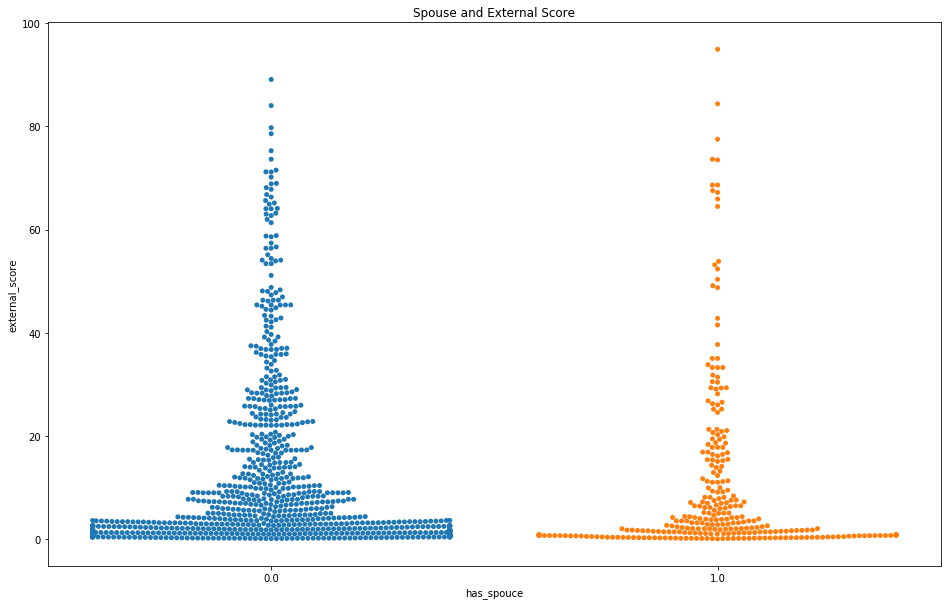

In [12]:
plt.figure(figsize=(16,10))
sns.swarmplot(x="has_spouce", y="external_score", data=df)
plt.title("Spouse and External Score")

### External Score and Target

Text(0.5, 1.0, 'Target and External Score')

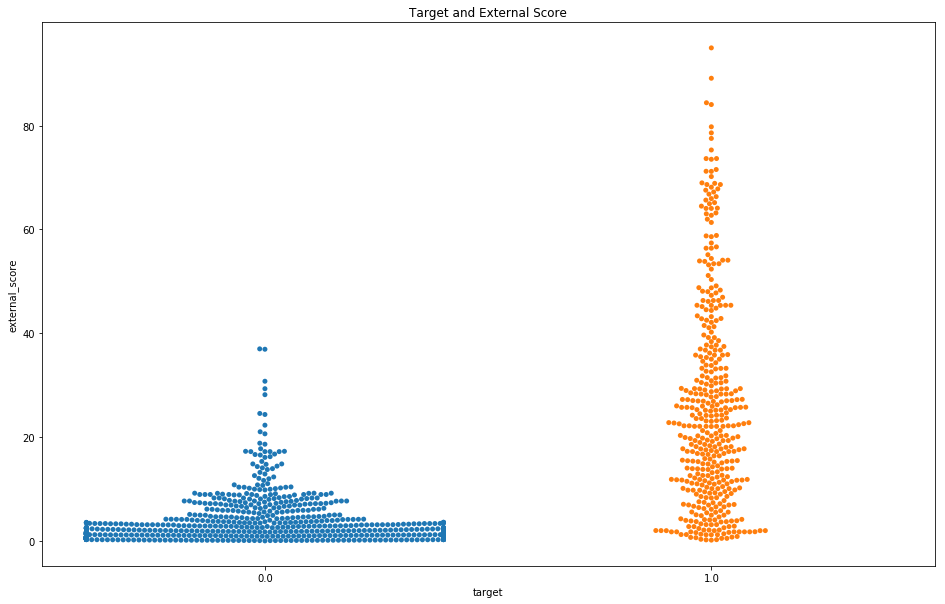

In [13]:
plt.figure(figsize=(16,10))
sns.swarmplot(x="target", y="external_score", data=df)
plt.title("Target and External Score")

In [14]:
df[["external_score", "target"]].corr()

,external_score,target
external_score,1.000000,0.650768
target,0.650768,1.000000


**Observations:** As we can see from the plot, there seems to be a correlation between the "external_score" of the client and whether they defaulted or not. Calculating the correlation score confirms our observations. It looks like any client with a "external_score" above 40 defaults, which means that having a lower score is better than having a high one.

Text(0.5, 1.0, 'Big City and External Score')

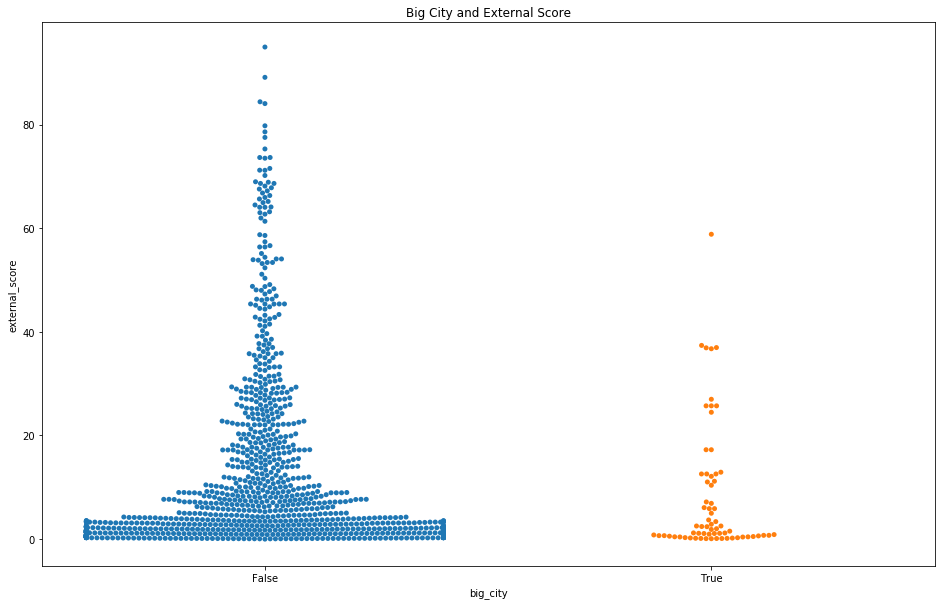

In [15]:
plt.figure(figsize=(16,10))
sns.swarmplot(x="big_city", y="external_score", data=df)
plt.title("Big City and External Score")

**Observations:** This seems to tell us that the majority of people who don't live in the big city have a "external_score" less than 40, which means that they won't default. Almost every client who lives in the big city has a "external_score" less than 40. There seems to be correlation between living in the big city and not defaulting.

In [16]:
df.groupby(["big_city", "target"])["target"].count()

big_city  target
False     0.0       732
          1.0       401
True      0.0        48
          1.0        19
Name: target, dtype: int64

Text(0.5, 1.0, 'Target and Income Gross')

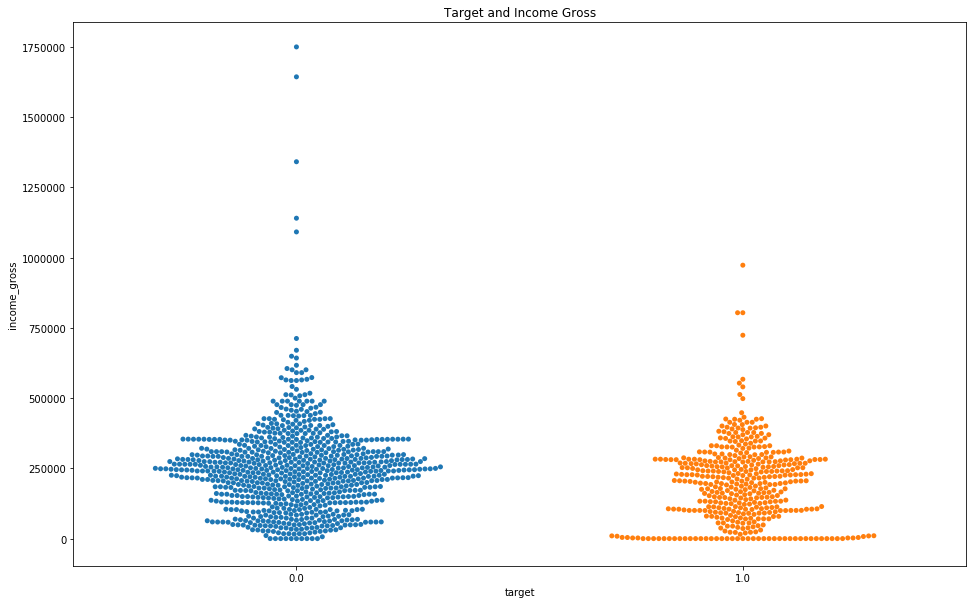

In [17]:
plt.figure(figsize=(16,10))
sns.swarmplot(x="target", y="income_gross", data=df)
plt.title("Target and Income Gross")

In [18]:
df[["income_gross", "target"]].corr()

,income_gross,target
income_gross,1.000000,-0.153872
target,-0.153872,1.000000


**Observations:** There doesn't seem to be any strong correlation between how much a client makes and weather they default or not. Although the majority of people with a lower gross income does not default

## Data Cleaning

### Dropping columns
Removing columns that don't seem to provide much useful information when predicting loan default. These are columns that meet any of the following criteria:

1. High percentage of missing values
2. Pairwise correlation (Redundant columns)
3. Low variation in the values
4. Non informative (i.e. id)

By dropping unsuful columns, we will make it computationally easier to do better feature selection during the model building process.

In [60]:
drop_colums = ["id", "email_domain", "contact_channel", "debt_requests_count", "housing_rent", "housing_rent", "credit_used_account", "customer_postal", "lender_id", "inquiries_count_12m", "loan_fee", "loan_interest", "hour_1", "day", "housing_base_cost"]
clean_df = df.drop(columns=drop_colums)
clean_df.head()

,external_score,income_tax,credit_used,e_mal_count,a_mal_count,credit_count,income_gross,capital_income,salary_surplus,credit_approved,...,inquiries_count,credit_used_blanco,payment_remarks_amount,e_mal_active_amount,a_mal_active_amount,blanco_amount,credit_card_amount,big_city,loan_type,target
0,19.33400,57500.0,204080.0,0.0,0.0,8.0,238800.0,0.0,260400.0,214302.0,...,8.0,132302.0,0.0,0.0,0.0,132302.0,71778.0,False,pos,1.0
1,0.60314,45400.0,367.0,0.0,0.0,1.0,216800.0,0.0,216900.0,367.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,pos,0.0
2,30.46367,43500.0,579783.0,0.0,0.0,13.0,221000.0,0.0,276600.0,585991.0,...,46.0,541885.0,0.0,0.0,0.0,541885.0,12792.0,False,blanco-,1.0
3,33.22719,47000.0,315891.0,0.0,0.0,9.0,205000.0,0.0,278900.0,336012.0,...,45.0,251012.0,0.0,0.0,0.0,251012.0,64879.0,False,pos,1.0
4,24.68127,3600.0,1033.0,0.0,0.0,1.0,46000.0,0.0,46600.0,1033.0,...,22.0,0.0,0.0,0.0,0.0,0.0,0.0,False,pos,1.0


In [61]:
clean_df.dropna(how="any", inplace=True)

In [62]:
clean_df.shape

(1198, 26)

### Saving the clean data

In [63]:
clean_df.to_pickle("clean_df.pkl")